In [1]:
from keras import models, layers
from keras.layers.core import *
from keras.layers.convolutional import *
from keras.layers.embeddings import *
from keras.layers.recurrent import *
from keras.layers.wrappers import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import os
print os.getcwd()
from data_utils import open_ds

/home/MSS/nathan-west/code/elephant-tusks


Using TensorFlow backend.


In [283]:
ds = open_ds()
label_list = list(set([x[0] for x in ds.keys()]))

snrs = []
total_nvecs = 0
for modulation, snr in ds.keys():
    snrs.append(snr)
    total_nvecs += ds[(modulation, snr)].shape[0]
print total_nvecs
snrs.sort()
snrs = set(snrs)
print snrs

162060
set([0, 16, 2, 4, 6, 8, 12, 10, -20, 18, -18, -16, -14, -12, 14, -10, -8, -6, -4, -2])


total nvecs is 162060 
train size is 129648 
(129640, 11)
training_data size is  (129640, 2, 128)
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103
nvecs in this snr is 8103


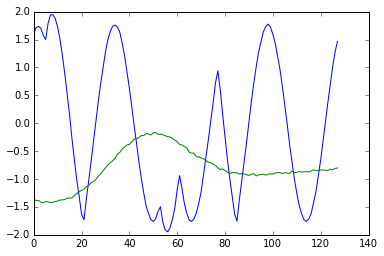

In [310]:
# get all of the mods
label_list = list(set([x[0] for x in ds.keys()]))
# Make the one-hot label arrays
num_labels = label_list.__len__()
labels_onehot = []
labels_onehot_dict = {}
for mod_indx in range(num_labels):
    labels_onehot.append(np.zeros([num_labels]))
    labels_onehot[mod_indx][mod_indx] = 1
    labels_onehot_dict[label_list[mod_indx]] = labels_onehot[mod_indx]

def reformat_ds(ds, modulation):
    """
    Transform dataset from an array of [i],[q] arrays to an array of [i,q]
    :param ds: 
    :return: 
    """
    num_vecs, nchans, vec_length = ds.shape
    transformed_ds = np.zeros((num_vecs, nchans, vec_length), dtype=ds.dtype)
    ds_labels = np.zeros((num_vecs, num_labels))
    indx = 0
    for vec in ds:
        #transformed_ds[indx][0] = vec[0]
        #transformed_ds[indx][1] = vec[1]
        ds_labels[indx] = labels_onehot_dict[modulation]
        indx += 1
    return (ds, ds_labels)

def onehot_to_class(onehot_labels):
    """
    A utility for converting onehot encodings to a class number
    :param onehot_labels: a numpy array with a onehot encodings
    :return: a numpy array with classes
    """
    return np.array([np.argmax(onehot) for onehot in onehot_labels])

def accuracy(predictions, labels):
    print predictions.shape
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def extract_desired_snrs(desired_snr=None):
    nvecs = 0
    for modulation, snr in ds.keys():
        if desired_snr == snr or desired_snr is None:
            nvecs += ds[(modulation, desired_snr)].shape[0]

    print "nvecs in this snr is %i" % nvecs
    ds_vecs = np.empty((nvecs, 2, 128), dtype=np.float32)
    ds_labels = np.empty((nvecs, num_labels), dtype=np.float32)

    # extract and reformat the data we care about
    indx = 0
    for modulation, snr in ds.keys():
        if desired_snr == snr or desired_snr == None:
            # This really just gives us a one-hot encoded vector
            (mod_vecs, mod_labels) = reformat_ds(ds[(modulation, snr)], modulation)
            nmodvecs = mod_vecs.shape[0]
            #print "mod %s has %i vecs" % (modulation, nmodvecs)
            ds_vecs[indx:indx+nmodvecs] = mod_vecs[:]
            ds_labels[indx:indx+nmodvecs] = mod_labels[:]
            indx += nmodvecs
    # scramble the data
    vec_size = ds_vecs.shape[1]
    #print "we got a total of %i vecs " % nvecs
    permuter = np.random.permutation(nvecs)
    shuffled_ds = ds_vecs[permuter]
    shuffled_labels = ds_labels[permuter]
    return (shuffled_ds, shuffled_labels, nvecs)

snr_keyed_ds = {}
snr_keyed_labels = {}
snr_keyed_validation_data = {}
snr_keyed_validation_labels = {}

print "total nvecs is %i " % total_nvecs
train_size = int(total_nvecs * .8)
per_snr_train_size = train_size / 20
print "train size is %i " % train_size
valid_size = total_nvecs - 20*per_snr_train_size
per_snr_valid_size = valid_size/20
training_data = np.zeros((20*per_snr_train_size, 2, 128))
training_labels = np.zeros((20*per_snr_train_size, label_list.__len__()))
valid_data = np.zeros((20*per_snr_valid_size, 2, 128))
valid_labels = np.zeros((20*per_snr_valid_size, label_list.__len__()))
print training_labels.shape
print "training_data size is ", training_data.shape
train_indx = 0
valid_indx = 0
snrs_list = list(snrs)
snrs_list.sort()
this_total_nvecs = 0
for snr in snrs_list:
    (this_snr_ds, this_snr_labels, nvecs) = extract_desired_snrs(snr)
    snr_keyed_ds[snr] = this_snr_ds
    snr_keyed_labels[snr] = this_snr_labels
    training_data[train_indx:train_indx+per_snr_train_size][:][:] = snr_keyed_ds[snr][0:per_snr_train_size]
    training_labels[train_indx:train_indx+per_snr_train_size][:] = snr_keyed_labels[snr][0:per_snr_train_size]
    
    valid_data[valid_indx:valid_indx+per_snr_valid_size][:][:] = snr_keyed_ds[snr][per_snr_train_size:per_snr_train_size+per_snr_valid_size]
    valid_labels[valid_indx:valid_indx+per_snr_valid_size][:] = snr_keyed_labels[snr][per_snr_train_size:per_snr_train_size+per_snr_valid_size]
    
    snr_keyed_validation_data[snr] = valid_data[valid_indx:valid_indx+per_snr_valid_size][:][:]
    snr_keyed_validation_labels[snr] = valid_labels[valid_indx:valid_indx+per_snr_valid_size][:]
    train_indx += per_snr_train_size
    valid_indx += per_snr_valid_size


# sanity check that the last placed vectors make sense
plt.plot(training_data[-1][0])
plt.plot(valid_data[-1][0])
plt.show()

# now we have training_data, valid_data that are vectors of 2x128 vectors
# and we have snr_keyed_validation_data and snr_keyed_validation_labels

# our training data is actually sorted by snr, so we should mix it up a bit
# also, we need to add a dimension to ds
train_permuter = np.random.permutation(training_data.shape[0])
train_ds = training_data[train_permuter].reshape(training_data.shape[0], 1, 2, 128)
train_labels = training_labels[train_permuter]
valid_ds = valid_data.reshape(valid_data.shape[0], 1, 2, 128)

#train_ds = t[0:train_size]
#train_ds = train_ds.reshape(train_ds.shape[0], 1, 2, 128)
#train_labels = shuffled_labels[0:train_size]
#valid_ds = shuffled_ds[train_size+1:train_size+valid_size]
#valid_ds = valid_ds.reshape(valid_ds.shape[0], 1, 2, 128)
#valid_labels = shuffled_labels[train_size+1:train_size+valid_size]

In [ ]:
# Make a model
#convmflstm = models.Sequential()
#convmflstm.add(Convolution2D(64, 2, 8, init='glorot_uniform', border_mode='same', input_shape=(1, 2, 128)))
#convmflstm.add(MaxPooling2D(pool_size=(1,8)))
#convmflstm.add(TimeDistributed(LSTM(64)))
#convmflstm.add(Flatten())
#convmflstm.add(Dense(256))
#convmflstm.add(Activation("relu"))
#convmflstm.add(Dropout(0.75))
#convmflstm.add(Dense(256))
#convmflstm.add(Dropout(0.75))
#convmflstm.add(Activation("relu"))
#convmflstm.add(Dense(output_dim=num_labels, init="glorot_uniform"))
#convmflstm.add(Activation("softmax"))
#convmflstm.compile(loss='categorical_crossentropy', optimizer='adam')
#convmflstm.fit(train_ds, train_labels, nb_epoch=200, batch_size=512)

from fourier import Fourier
# Make a model for classification
modclassifer = models.Sequential()
modclassifer.add(Reshape((2,128),input_shape=(1,2,128)))

modclassifer.add(Fourier(512))
modclassifer.add(Reshape((1,512*2)))

modclassifer.add(Flatten())
modclassifer.add(Dense(256))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.2))
modclassifer.add(Dense(128))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.2))
modclassifer.add(Dense(64))
modclassifer.add(Activation("relu"))
modclassifer.add(Dense(32))
modclassifer.add(Dropout(0.2))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.2))
modclassifer.add(Dense(32))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.2))
modclassifer.add(Dense(32))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.2))
modclassifer.add(Dense(32))
modclassifer.add(Activation("relu"))
modclassifer.add(Dense(32))
modclassifer.add(Activation("relu"))
modclassifer.add(Dense(32))
modclassifer.add(Activation("relu"))


#modclassifer.add(Fourier(128))
#modclassifer.add(Reshape((1,2*128)))
#modclassifer.add(Flatten())

#modclassifer.add(Dense(256))
#modclassifer.add(Activation("relu"))

modclassifer.add(Dense(output_dim=num_labels, init="glorot_uniform"))
modclassifer.add(Activation("softmax"))
modclassifer.compile(loss='categorical_crossentropy', optimizer='adam')
modclassifer.fit(train_ds, train_labels, nb_epoch=500, batch_size=512)

#convmf = models.Sequential()
#convmf.add(Convolution2D(64, 2, 8, init='glorot_uniform', border_mode='same', input_shape=(1, 2, 128)))
#convmf.add(MaxPooling2D(pool_size=(1,8)))
#convmf.add(TimeDistributed(Dense(256)))
#convmf.add(Flatten())
#convmf.add(Dropout(0.75))
#convmf.add(Dense(256))
#convmf.add(Dropout(0.75))
#convmf.add(Activation("relu"))
#convmf.add(Dense(output_dim=num_labels, init="glorot_uniform"))
#convmf.add(Activation("softmax"))
#convmf.compile(loss='categorical_crossentropy', optimizer='adam')
#convmf.fit(train_ds, train_labels, nb_epoch=200, batch_size=512)


#modclassifer = models.Sequential()
#modclassifer.add(Convolution2D(64, 1, 8, init='glorot_uniform', border_mode='same', input_shape=(1, 2, 128)))
#modclassifer.add(Activation("relu"))
#modclassifer.add(Convolution2D(16, 2, 3, init='glorot_uniform', border_mode='same'))
#modclassifer.add(Activation("relu"))

#modclassifer.add(Flatten())
#modclassifer.add(Dense(256))
#modclassifer.add(Activation("relu"))
#modclassifer.add(Dropout(0.75))
#modclassifer.add(Dense(256))
#modclassifer.add(Dropout(0.75))
#modclassifer.add(Activation("relu"))
#modclassifer.add(Dense(output_dim=num_labels, init="glorot_uniform"))
#modclassifer.add(Activation("softmax"))
#modclassifer.compile(loss='categorical_crossentropy', optimizer='adam')
#modclassifer.fit(train_ds, train_labels, nb_epoch=5, batch_size=512)

Epoch 1/500
129640/129640 [==============================] - 12s - loss: 2.2443    
Epoch 2/500
129640/129640 [==============================] - 11s - loss: 1.9303    
Epoch 3/500
129640/129640 [==============================] - 11s - loss: 1.7163    
Epoch 4/500
129640/129640 [==============================] - 11s - loss: 1.6084    
Epoch 5/500
129640/129640 [==============================] - 11s - loss: 1.4996    
Epoch 6/500
129640/129640 [==============================] - 11s - loss: 1.4256    
Epoch 7/500
129640/129640 [==============================] - 11s - loss: 1.3831    
Epoch 8/500
129640/129640 [==============================] - 11s - loss: 1.3552    
Epoch 9/500
129640/129640 [==============================] - 11s - loss: 1.3315    
Epoch 10/500
129640/129640 [==============================] - 11s - loss: 1.3120    
Epoch 11/500
129640/129640 [==============================] - 12s - loss: 1.2970    
Epoch 12/500
129640/129640 [==============================] - 12s - loss: 

In [ ]:
#classes_convmflstm = convmflstm.predict_classes(valid_ds, batch_size=128)
#classes_convmf = convmf.predict_classes(valid_ds, batch_size=128)
classes_fourier = modclassifer.predict_classes(valid_ds, batch_size=128)

# Convert classes to onehot encoding
classes_onehot = np.zeros([valid_labels.__len__(), num_labels])
indx = 0
for clasify in classes_convmflstm:
    classes_onehot[indx] = labels_onehot[clasify]
    indx += 1

print "Validation accuracy: %1.3f" % (accuracy(classes_onehot, valid_labels))
#
#indx = 0
#for clasify in classes_convmf:
#    classes_onehot[indx] = labels_onehot[clasify]
#    indx += 1
#
#print "Validation accuracy: %1.3f" % (accuracy(classes_onehot, valid_labels))

classes_onehot = np.zeros([valid_labels.__len__(), num_labels])
indx = 0
for clasify in classes_fourier:
    classes_onehot[indx] = labels_onehot[clasify]
    indx += 1

print "Validation accuracy: %1.3f" % (accuracy(classes_onehot, valid_labels))

[[1199    0    0    0    0    2   21    2    0   82  118]
 [  19 1863   34   16  822   95   44   13    0   37    8]
 [  89   17 2004   14   18  101  120   17   14  140   59]
 [  10    3    0 1754    0   11    7   86    3   10    1]
 [  11  221    6   13 1443   55   22    6    2   18    3]
 [ 349  302  290  315  492 4056  684  131   95  610  183]
 [ 239  129  220  127  139  301 3443   37   16  416  158]
 [   0    1    0   17    0    2    0  816   13    0    0]
 [   1    2    0    0    3    4    1    4  647    0    0]
 [ 403  210  278  220  235  497  546  119   37 3692  244]
 [ 172    0    0    0    0    0   14    0    0    9  848]]


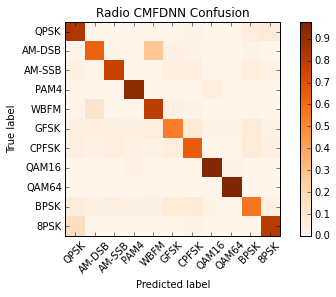

In [354]:
def plot_confusion_matrix(cm, target_names=None, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# onehot_labels_dict has keys that are string labels and values that are one-hot encodings
# This is probably in order, but we should make a new list of labels that is in order of class
# First make a dict of class: 'string of class'
inorder_classes = dict()
for k in labels_onehot_dict:
    inorder_classes[np.argmax(labels_onehot_dict[k])] = k

inorder_labels = tuple([inorder_classes[c] for c in xrange(inorder_classes.__len__())])

cm = confusion_matrix(classes, onehot_to_class(valid_labels))
print cm
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
plot_confusion_matrix(cm_normalized, target_names=inorder_labels, title="Radio CMFDNN Confusion")
fig.set_facecolor("white")
#plt.savefig("CLDNN matrix:50epoch,ConvMaxLstmDenseDense.png")
plt.show()

1621/1621 [==============================] - 0s     
(1621, 11)
0 dB is at 77.791
1621/1621 [==============================] - 0s     
(1621, 11)
16 dB is at 82.850
1621/1621 [==============================] - 0s     
(1621, 11)
2 dB is at 76.928
1621/1621 [==============================] - 0s     
(1621, 11)
4 dB is at 80.382
1621/1621 [==============================] - 0s     
(1621, 11)
6 dB is at 81.740
1621/1621 [==============================] - 0s     
(1621, 11)
8 dB is at 77.051
1621/1621 [==============================] - 0s     
(1621, 11)
12 dB is at 84.886
1621/1621 [==============================] - 0s     
(1621, 11)
10 dB is at 82.171
1621/1621 [==============================] - 0s     
(1621, 11)
-20 dB is at 13.819
1621/1621 [==============================] - 0s     
(1621, 11)
18 dB is at 85.071
1621/1621 [==============================] - 0s     
(1621, 11)
-18 dB is at 13.819
1621/1621 [==============================] - 0s     
(1621, 11)
-16 dB is at 15.546
1621/1

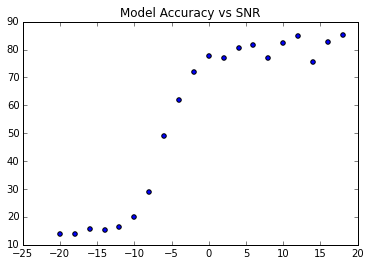

In [355]:
num_snrs = snr_keyed_validation_data.keys().__len__()
model_accuracy = np.zeros(num_snrs)
snrs_array = np.zeros(num_snrs)
snr_indx = 0
for (snr, vectors) in snr_keyed_validation_data.items():
    predictions = modclassifer.predict_classes(vectors.reshape(vectors.shape[0],1,2,128))
    classes_onehot = np.zeros([predictions.shape[0], num_labels])
    indx = 0
    for clasify in predictions:
        classes_onehot[indx] = labels_onehot[clasify]
        indx += 1
    this_accuracy = accuracy(classes_onehot, snr_keyed_validation_labels[snr])
    print "%i dB is at %2.3f" % (snr,this_accuracy)
    model_accuracy[snr_indx] = this_accuracy
    snrs_array[snr_indx] = snr
    snr_indx += 1

plt.scatter(snrs_array, model_accuracy)
plt.title("Model Accuracy vs SNR")
plt.show()

In [331]:
# Make a model
modclassifer = models.Sequential()
modclassifer.add(Convolution2D(64, 1, 8, init='glorot_uniform', border_mode='same', input_shape=(1, 2, 128)))
modclassifer.add(Activation("relu"))
modclassifer.add(MaxPooling2D(pool_size=(1,8)))
modclassifer.add(TimeDistributed(LSTM(64)))
modclassifer.add(Flatten())
modclassifer.add(Dense(256))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.75))
modclassifer.add(Dense(256))
modclassifer.add(Dropout(0.75))
modclassifer.add(Activation("relu"))
modclassifer.add(Dense(output_dim=num_labels, init="glorot_uniform"))
modclassifer.add(Activation("softmax"))
modclassifer.compile(loss='categorical_crossentropy', optimizer='adam')
modclassifer.fit(train_ds, train_labels, nb_epoch=100, batch_size=512)

Epoch 1/100
129640/129640 [==============================] - 241s - loss: 2.0044   
Epoch 2/100
129640/129640 [==============================] - 239s - loss: 1.6470   
Epoch 3/100
129640/129640 [==============================] - 239s - loss: 1.5006   
Epoch 4/100
129640/129640 [==============================] - 239s - loss: 1.4231   
Epoch 5/100
129640/129640 [==============================] - 239s - loss: 1.3376   
Epoch 6/100
129640/129640 [==============================] - 243s - loss: 1.2374   
Epoch 7/100
129640/129640 [==============================] - 243s - loss: 1.1943   
Epoch 8/100
129640/129640 [==============================] - 244s - loss: 1.1657   
Epoch 9/100
129640/129640 [==============================] - 245s - loss: 1.1475   
Epoch 10/100
129640/129640 [==============================] - 244s - loss: 1.1296   
Epoch 11/100
129640/129640 [==============================] - 244s - loss: 1.1193   
Epoch 12/100
129640/129640 [==============================] - 244s - loss:

In [332]:
classes = modclassifer.predict_classes(valid_ds, batch_size=128)

# Convert classes to onehot encoding
classes_onehot = np.zeros([valid_labels.__len__(), num_labels])
indx = 0
for clasify in classes:
    classes_onehot[indx] = labels_onehot[clasify]
    indx += 1

print classes_onehot.shape
print valid_labels.shape
print valid_labels
print "Validation accuracy: %1.3f" % (accuracy(classes_onehot, valid_labels))

32420/32420 [==============================] - 28s    
(32420, 11)
(32420, 11)
[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(32420, 11)
Validation accuracy: 66.536


[[1041    0    6    0    0    7   73    0    0   61  148]
 [   0 1663    0    1  459   29    3    0    0    5    1]
 [  50    4 1891   11    8   56   51   14   13   62   36]
 [   8    1    5 1755    0   14   16   45    2   21    4]
 [  22  382   27   18 1856  113   44    5    0   49   12]
 [  50   74   48   34  120 3420  173   26    5   94   34]
 [ 834  609  814  583  699 1420 4404  269  147 1474  504]
 [   2    1    0   35    0    8    3  871   55    2    0]
 [   0    0    0    0    0    0    0    0  605    0    0]
 [ 135   14   38   39   10   55  110    1    0 3238   56]
 [ 350    0    3    0    0    2   25    0    0    8  827]]


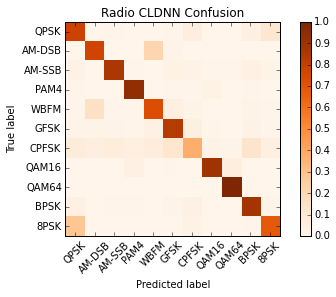

In [333]:
def plot_confusion_matrix(cm, target_names=None, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# onehot_labels_dict has keys that are string labels and values that are one-hot encodings
# This is probably in order, but we should make a new list of labels that is in order of class
# First make a dict of class: 'string of class'
inorder_classes = dict()
for k in labels_onehot_dict:
    inorder_classes[np.argmax(labels_onehot_dict[k])] = k

inorder_labels = tuple([inorder_classes[c] for c in xrange(inorder_classes.__len__())])

cm = confusion_matrix(classes, onehot_to_class(valid_labels))
print cm
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
plot_confusion_matrix(cm_normalized, target_names=inorder_labels, title="Radio CLDNN Confusion")
fig.set_facecolor("white")
plt.savefig("CLDNN matrix:10epoch,ConvMaxLstmDenseLong.png")
plt.show()

1621/1621 [==============================] - 1s     
(1621, 11)
91.2399753239
1621/1621 [==============================] - 1s     
(1621, 11)
97.3473164713
1621/1621 [==============================] - 1s     
(1621, 11)
91.9802590993
1621/1621 [==============================] - 1s     
(1621, 11)
94.3244910549
1621/1621 [==============================] - 1s     
(1621, 11)
93.9543491672
1621/1621 [==============================] - 1s     
(1621, 11)
89.9444787168
1621/1621 [==============================] - 1s     
(1621, 11)
97.9642196175
1621/1621 [==============================] - 1s     
(1621, 11)
96.9771745836
1621/1621 [==============================] - 1s     
(1621, 11)
13.7569401604
1621/1621 [==============================] - 1s     
(1621, 11)
95.3115360888
1621/1621 [==============================] - 1s     
(1621, 11)
13.8803207896
1621/1621 [==============================] - 1s     
(1621, 11)
15.4225786552
1621/1621 [==============================] - 1s     
(1621, 11)


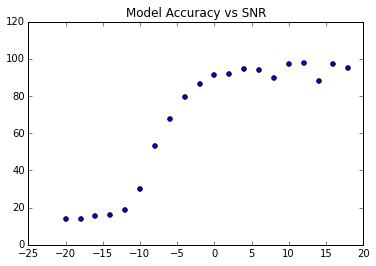

In [334]:
num_snrs = snr_keyed_validation_data.keys().__len__()
model_accuracy = np.zeros(num_snrs)
snrs_array = np.zeros(num_snrs)
snr_indx = 0
for (snr, vectors) in snr_keyed_validation_data.items():
    predictions = modclassifer.predict_classes(vectors.reshape(vectors.shape[0],1,2,128))
    classes_onehot = np.zeros([predictions.shape[0], num_labels])
    indx = 0
    for clasify in predictions:
        classes_onehot[indx] = labels_onehot[clasify]
        indx += 1
    this_accuracy = accuracy(classes_onehot, snr_keyed_validation_labels[snr])
    print this_accuracy
    model_accuracy[snr_indx] = this_accuracy
    snrs_array[snr_indx] = snr
    snr_indx += 1

plt.scatter(snrs_array, model_accuracy)
plt.title("Model Accuracy vs SNR")
plt.show()

In [335]:
# Make a model
modclassifer = models.Sequential()
modclassifer.add(Convolution2D(64, 1, 8, init='glorot_uniform', border_mode='same', input_shape=(1, 2, 128)))
modclassifer.add(Activation("relu"))
modclassifer.add(Convolution2D(16, 1, 4, init='glorot_uniform', border_mode='same'))
#modclassifer.add(MaxPooling2D(pool_size=(1,8)))
modclassifer.add(TimeDistributed(LSTM(8)))
modclassifer.add(Flatten())
modclassifer.add(Dense(256))
modclassifer.add(Activation("relu"))
modclassifer.add(Dropout(0.75))
modclassifer.add(Dense(256))
modclassifer.add(Dropout(0.75))
modclassifer.add(Activation("relu"))
modclassifer.add(Dense(output_dim=num_labels, init="glorot_uniform"))
modclassifer.add(Activation("softmax"))
modclassifer.compile(loss='categorical_crossentropy', optimizer='adam')
modclassifer.fit(train_ds, train_labels, nb_epoch=100, batch_size=512)

Epoch 1/100
129640/129640 [==============================] - 137s - loss: 2.0066   
Epoch 2/100
129640/129640 [==============================] - 132s - loss: 1.3682   
Epoch 3/100
129640/129640 [==============================] - 126s - loss: 1.2173   
Epoch 4/100
129640/129640 [==============================] - 125s - loss: 1.1415   
Epoch 5/100
129640/129640 [==============================] - 126s - loss: 1.1028   
Epoch 6/100
129640/129640 [==============================] - 126s - loss: 1.0720   
Epoch 7/100
129640/129640 [==============================] - 125s - loss: 1.0476   
Epoch 8/100
129640/129640 [==============================] - 125s - loss: 1.0363   
Epoch 9/100
129640/129640 [==============================] - 124s - loss: 1.0216   
Epoch 10/100
129640/129640 [==============================] - 125s - loss: 1.0130   
Epoch 11/100
129640/129640 [==============================] - 124s - loss: 1.0049   
Epoch 12/100
129640/129640 [==============================] - 124s - loss:

In [336]:
classes = modclassifer.predict_classes(valid_ds, batch_size=128)

# Convert classes to onehot encoding
classes_onehot = np.zeros([valid_labels.__len__(), num_labels])
indx = 0
for clasify in classes:
    classes_onehot[indx] = labels_onehot[clasify]
    indx += 1

print classes_onehot.shape
print valid_labels.shape
print valid_labels
print "Validation accuracy: %1.3f" % (accuracy(classes_onehot, valid_labels))

32420/32420 [==============================] - 17s    
(32420, 11)
(32420, 11)
[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(32420, 11)
Validation accuracy: 67.134


[[1199    0    0    0    0    2   21    2    0   82  118]
 [  19 1863   34   16  822   95   44   13    0   37    8]
 [  89   17 2004   14   18  101  120   17   14  140   59]
 [  10    3    0 1754    0   11    7   86    3   10    1]
 [  11  221    6   13 1443   55   22    6    2   18    3]
 [ 349  302  290  315  492 4056  684  131   95  610  183]
 [ 239  129  220  127  139  301 3443   37   16  416  158]
 [   0    1    0   17    0    2    0  816   13    0    0]
 [   1    2    0    0    3    4    1    4  647    0    0]
 [ 403  210  278  220  235  497  546  119   37 3692  244]
 [ 172    0    0    0    0    0   14    0    0    9  848]]


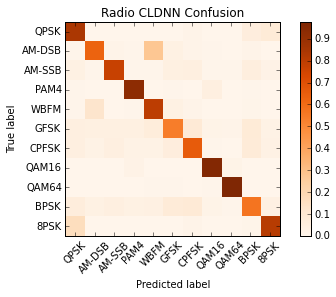

In [337]:
def plot_confusion_matrix(cm, target_names=None, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# onehot_labels_dict has keys that are string labels and values that are one-hot encodings
# This is probably in order, but we should make a new list of labels that is in order of class
# First make a dict of class: 'string of class'
inorder_classes = dict()
for k in labels_onehot_dict:
    inorder_classes[np.argmax(labels_onehot_dict[k])] = k

inorder_labels = tuple([inorder_classes[c] for c in xrange(inorder_classes.__len__())])

cm = confusion_matrix(classes, onehot_to_class(valid_labels))
print cm
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
plot_confusion_matrix(cm_normalized, target_names=inorder_labels, title="Radio CLDNN Confusion")
fig.set_facecolor("white")
plt.savefig("CLDNN matrix:10epoch,ConvMaxLstmDenseLong.png")
plt.show()

1621/1621 [==============================] - 1s     
(1621, 11)
91.548426897
1621/1621 [==============================] - 1s     
(1621, 11)
95.2498457742
1621/1621 [==============================] - 1s     
(1621, 11)
92.5971622455
1621/1621 [==============================] - 1s     
(1621, 11)
95.7433682912
1621/1621 [==============================] - 1s     
(1621, 11)
93.6458975941
1621/1621 [==============================] - 1s     
(1621, 11)
90.8698334362
1621/1621 [==============================] - 1s     
(1621, 11)
95.6199876619
1621/1621 [==============================] - 1s     
(1621, 11)
96.4836520666
1621/1621 [==============================] - 1s     
(1621, 11)
14.5589142505
1621/1621 [==============================] - 1s     
(1621, 11)
96.9771745836
1621/1621 [==============================] - 1s     
(1621, 11)
16.101172116
1621/1621 [==============================] - 1s     
(1621, 11)
16.4713140037
1621/1621 [==============================] - 1s     
(1621, 11)
18

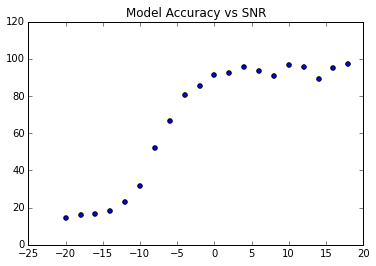

In [338]:
num_snrs = snr_keyed_validation_data.keys().__len__()
model_accuracy = np.zeros(num_snrs)
snrs_array = np.zeros(num_snrs)
snr_indx = 0
for (snr, vectors) in snr_keyed_validation_data.items():
    predictions = modclassifer.predict_classes(vectors.reshape(vectors.shape[0],1,2,128))
    classes_onehot = np.zeros([predictions.shape[0], num_labels])
    indx = 0
    for clasify in predictions:
        classes_onehot[indx] = labels_onehot[clasify]
        indx += 1
    this_accuracy = accuracy(classes_onehot, snr_keyed_validation_labels[snr])
    print this_accuracy
    model_accuracy[snr_indx] = this_accuracy
    snrs_array[snr_indx] = snr
    snr_indx += 1

plt.scatter(snrs_array, model_accuracy)
plt.title("Model Accuracy vs SNR")
plt.show()